# Домашнее задание

Домашнее задание состоит из нескольких блоков.


## Эксперименты в ipynb ноутбуках (15 баллов)
- Необходимо будет перебрать $N$ моделей $(N \geq 2)$ матричной факторизации и перебрать у них $K$ гиперпараметров $(K \geq 2)$ **(6 баллов)**
    - Для перебора гиперпараметров можно использовать [`Optuna`](https://github.com/optuna/optuna), [`Hyperopt`](https://github.com/hyperopt/hyperopt)
- Воспользоваться методом приближенного поиска соседей для выдачи рекомендаций. **(3 балла)**
    - Можно использовать любые удобные: [`Annoy`](https://github.com/spotify/annoy), [`nmslib`](https://github.com/nmslib/nmslib) и.т.д
- Добавить 3 "аватаров" (искусственных пользователей) и посмотреть рекомендации итоговой модели на них. Объяснить почему добавили именно таких пользователей. **(3 балла)**
- Придумать как можно обработать рекомендации для холодных пользователей. **(3 балла)**

Примечание: за невоспроизводимый код в ноутбуках (например, нарушен порядок выполнения ячеек, вызываются переменные, которые нигде не были объявлены ранее и.т.п) будут штрафы на усмотрение проверяющего.


## Реализация итоговой модели в сервисе (10 баллов)
- Пробитие бейзлайна $MAP@10 \geq 0.074921$ **(6 баллов)**
- Код сервиса соответствует критериям читаемости и воспроизводимости **(4 балла)**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import sys
# !{sys.executable} -m pip install rectools=0.3.0

In [3]:
import os
import time
from pathlib import Path

import numpy as np
import optuna
import pandas as pd

# import nmslib
from implicit.als import AlternatingLeastSquares
from lightfm import LightFM
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import MAP, Precision, Recall, calc_metrics
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel

In [4]:
Columns.Item

'item_id'

In [3]:
os.environ['OPENBLAS_NUM_THREADS'] = "1"
Columns.Datetime = 'last_watch_dt'
DATA_PATH = Path("../data/kion_train/")

In [4]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: user 2.23 s, sys: 464 ms, total: 2.69 s
Wall time: 2.9 s


# Preprocess Interactions

In [5]:
interactions.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
interactions.dtypes

user_id            int64
item_id            int64
last_watch_dt     object
total_dur          int64
watched_pct      float64
dtype: object

In [7]:
# Количество пустых значений в каждой колонке
interactions.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

In [8]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime], format='%Y-%m-%d')
interactions.dropna(inplace=True)

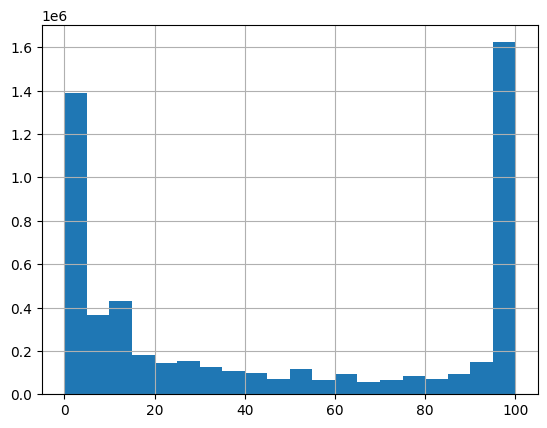

In [9]:
interactions['watched_pct'].hist(bins=20);

In [10]:
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


Разбиваем длительность просмотра на 5 частей, где:
 - от 0% до 20%  = 1,
 - от 21% до 40% = 2,
 - ... ,
 - от 80% до 100% = 5

In [11]:
interactions[Columns.Weight] = pd.cut(
    x=interactions['watched_pct'],
    bins=5,
    labels=[1, 2, 3, 4, 5]
)

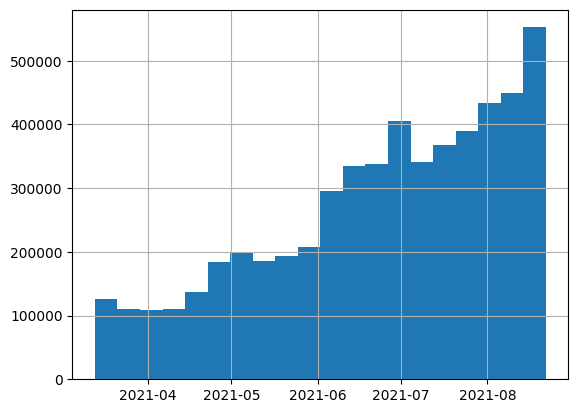

In [12]:
interactions[Columns.Datetime].hist(bins=20);

Видно, что кол-во пользователей растет

In [13]:
cold_users = interactions[Columns.User].value_counts()
cold_users = cold_users[cold_users < 3].index

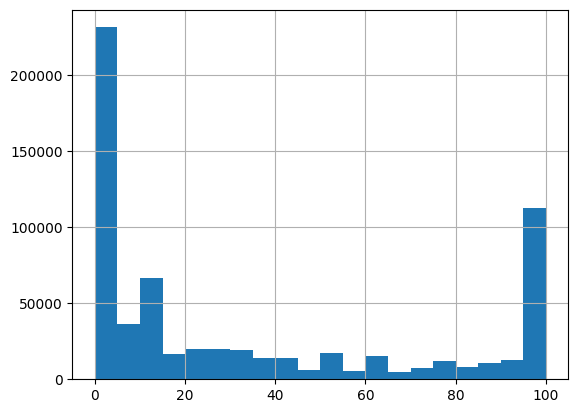

In [14]:
interactions[interactions[Columns.User].isin(cold_users)]['watched_pct'].hist(bins=20);

Для холодных пользователей, мы бы рекомендовали айтемы с самый высоким просмотром в среднем по холодным пользователям

In [15]:
cold_users_interactions = interactions[interactions[Columns.User].isin(cold_users)]
hot_users_interactions = interactions[~interactions[Columns.User].isin(cold_users)]

In [16]:
print('shape cold_users_interactions -', cold_users_interactions.shape[0])
cold_users_interactions.head()

shape cold_users_interactions - 650696


,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
10,791466,8199,2021-07-27,713,9.0,1
16,646903,16228,2021-07-23,57375,46.0,3
22,505244,15297,2021-08-15,15991,63.0,4
26,181144,10440,2021-08-08,27408,40.0,2
37,161176,10440,2021-07-29,22,0.0,1


In [17]:
print('shape hot_users_interactions -', hot_users_interactions.shape[0])
hot_users_interactions.head()

shape hot_users_interactions - 4824727


,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,4
1,699317,1659,2021-05-29,8317,100.0,5
2,656683,7107,2021-05-09,10,0.0,1
3,864613,7638,2021-07-05,14483,100.0,5
4,964868,9506,2021-04-30,6725,100.0,5


In [18]:
cold_users_interactions['item_id'].value_counts().to_frame().head()

,item_id
10440,69181
15297,64307
9728,28294
2657,25592
13865,22653


In [19]:
(
    cold_users_interactions[['item_id', 'total_dur']]
    .groupby('item_id')
    .mean()
    .sort_values(by='total_dur', ascending=False)
    .head(10)
    .index
)

Int64Index([609, 3825, 4895, 5069, 2271, 11566, 13390, 9954, 5733, 7434], dtype='int64', name='item_id')

# Делим на train и test

In [20]:
max_date = hot_users_interactions[Columns.Datetime].max()

In [21]:
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (4984443, 6)
test: (490980, 6)


In [22]:
train.drop(train.query("total_dur < 300").index, inplace=True)

In [23]:
drop_user = set(test[Columns.User]) - set(train[Columns.User])

In [24]:
test.drop(test[test[Columns.User].isin(drop_user)].index, inplace=True)

In [25]:
test

,user_id,item_id,last_watch_dt,total_dur,watched_pct,weight
9,203219,13582,2021-08-22,6975,100.0,5
54,200197,9335,2021-08-16,83,2.0,1
64,73446,14488,2021-08-19,6011,100.0,5
84,10010,512,2021-08-15,14,0.0,1
94,890735,14200,2021-08-16,1179,28.0,2
...,...,...,...,...,...,...
5476169,589589,983,2021-08-21,2403,43.0,3
5476188,590892,8618,2021-08-21,1335,23.0,2
5476191,857162,12360,2021-08-16,11,0.0,1
5476201,273558,10605,2021-08-21,34030,100.0,5


# User preprocess

In [26]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [27]:
users.isnull().sum()/840197

user_id     0.000000
age         0.016776
income      0.017586
sex         0.016462
kids_flg    0.000000
dtype: float64

In [28]:
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()

In [29]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
5,1037719,age_45_54,income_60_90,М,0


Заменяем Nan'ы на Unknown

In [30]:
users.fillna('Unknown', inplace=True)

In [31]:
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
user_features.head()

,id,value,feature
0,973171,М,sex
1,962099,М,sex
3,721985,Ж,sex
4,704055,Ж,sex
5,1037719,М,sex


# Item preprocess

In [32]:
items.sample(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
6657,602,film,Чем заняться дома?,Chem zanyat'sya doma?,2020.0,"мультфильм, комедии",Кипр,NaN,0.0,NaN,Наумов Артем,Саранцева Варя,"Чем заняться ребёнку, если никуда не получаетс...","2020, кипр, чем, заняться, дома"
12313,15798,film,В мире динозавров,NaN,2005.0,"русские, для детей, хочу всё знать, русские му...",Россия,NaN,0.0,NaN,Роберт Саакянц,NaN,"Познавательный мультфильм для детей, рассказыв...","мире, динозавров, 2005, Россия, динозавры, пут..."
8428,10616,film,Рождение нации,The Birth of a Nation,2016.0,"драмы, биография, историческое","США, Канада",NaN,18.0,NaN,Нэйт Паркер,"Нэйт Паркер, Арми Хаммер, Пенелопа Энн Миллер,...",Историко-драматический байопик о чернокожем ра...,"южные сша, рабство, биография, основанная на р..."


In [33]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       4745
release_year       98
genres              0
countries          37
for_kids        15397
age_rating          2
studios         14898
directors        1509
actors           2619
description         2
keywords          423
dtype: int64

In [34]:
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()

In [35]:
items.isna().sum()

item_id             0
content_type        0
title               0
title_orig       3775
release_year       31
genres              0
countries          14
for_kids        13415
age_rating          1
studios         13047
directors         939
actors           1858
description         0
keywords          388
dtype: int64

# Genre

In [36]:
# Explode genres to flatten table
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


# Content

In [37]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
content_feature.head()

,id,value,feature
0,10711,film,content_type
1,2508,film,content_type
2,10716,film,content_type
3,7868,film,content_type
4,16268,film,content_type


# Actors

In [38]:
items["actors"] = items["actors"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
actors_feature = items[["item_id", "actors"]].explode("actors")
actors_feature.columns = ["id", "value"]
actors_feature["feature"] = "actors"
actors_feature.head()

,id,value,feature
0,10711,адольфо фернандес,actors
0,10711,ана фернандес,actors
0,10711,дарио грандинетти,actors
0,10711,джеральдин чаплин,actors
0,10711,елена анайя,actors


# Keywords

In [39]:
items["keywords"] = items["keywords"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
keywords_feature = items[["item_id", "keywords"]].explode("keywords")
keywords_feature.columns = ["id", "value"]
keywords_feature["feature"] = "keywords"
keywords_feature.head()

,id,value,feature
0,10711,поговори,keywords
0,10711,ней,keywords
0,10711,2002,keywords
0,10711,испания,keywords
0,10711,друзья,keywords


# Countries

In [40]:
country_feature = items.reindex(columns=[Columns.Item, "countries"])
country_feature.columns = ["id", "value"]
country_feature["feature"] = "countries"
country_feature.head()

,id,value,feature
0,10711,Испания,countries
1,2508,США,countries
2,10716,Канада,countries
3,7868,Великобритания,countries
4,16268,СССР,countries


# Age Rating

In [41]:
age_feature = items.reindex(columns=[Columns.Item, "age_rating"])
age_feature.columns = ["id", "value"]
age_feature["feature"] = "age_feature"
age_feature.head()

,id,value,feature
0,10711,16.0,age_feature
1,2508,16.0,age_feature
2,10716,16.0,age_feature
3,7868,16.0,age_feature
4,16268,12.0,age_feature


# Studios

In [42]:
items.fillna('Unknown', inplace=True)

In [43]:
studios_feature = items.reindex(columns=[Columns.Item, "studios"])
studios_feature.columns = ["id", "value"]
studios_feature["feature"] = "studios"
studios_feature.head()

,id,value,feature
0,10711,Unknown,studios
1,2508,Unknown,studios
2,10716,Unknown,studios
3,7868,Unknown,studios
4,16268,Ленфильм,studios


### Конкатим все доп фичи в один датасет

In [44]:
item_features = pd.concat((genre_feature, content_feature, studios_feature, age_feature, country_feature))
item_features.sample(5)

,id,value,feature
2755,6781,Unknown,studios
1885,9843,Unknown,studios
7472,6909,12.0,age_feature
3395,10751,для детей,genre
3915,9872,триллеры,genre


# Metrics

In [45]:
metrics_name = {
    'Precision': Precision,
    'Recall': Recall,
    'MAP': MAP,
}

metrics = {}
for metric_name, metric in metrics_name.items():
    for k in range(1, 11):
        metrics[f'{metric_name}@{k}'] = metric(k=k)
metrics

{'Precision@1': Precision(k=1),
 'Precision@2': Precision(k=2),
 'Precision@3': Precision(k=3),
 'Precision@4': Precision(k=4),
 'Precision@5': Precision(k=5),
 'Precision@6': Precision(k=6),
 'Precision@7': Precision(k=7),
 'Precision@8': Precision(k=8),
 'Precision@9': Precision(k=9),
 'Precision@10': Precision(k=10),
 'Recall@1': Recall(k=1),
 'Recall@2': Recall(k=2),
 'Recall@3': Recall(k=3),
 'Recall@4': Recall(k=4),
 'Recall@5': Recall(k=5),
 'Recall@6': Recall(k=6),
 'Recall@7': Recall(k=7),
 'Recall@8': Recall(k=8),
 'Recall@9': Recall(k=9),
 'Recall@10': Recall(k=10),
 'MAP@1': MAP(k=1, divide_by_k=False),
 'MAP@2': MAP(k=2, divide_by_k=False),
 'MAP@3': MAP(k=3, divide_by_k=False),
 'MAP@4': MAP(k=4, divide_by_k=False),
 'MAP@5': MAP(k=5, divide_by_k=False),
 'MAP@6': MAP(k=6, divide_by_k=False),
 'MAP@7': MAP(k=7, divide_by_k=False),
 'MAP@8': MAP(k=8, divide_by_k=False),
 'MAP@9': MAP(k=9, divide_by_k=False),
 'MAP@10': MAP(k=10, divide_by_k=False)}

# Обучение моделей

In [46]:
K_RECOS = 10
RANDOM_STATE = 42
NUM_THREADS = 8
N_FACTORS = (32,)
N_EPOCHS = 1 # Lightfm
USER_ALPHA = 0 # Lightfm
ITEM_ALPHA = 0 # Lightfm
LEARNING_RATE = 0.05 # Lightfm

In [66]:
print('user_features -', set(user_features.feature))
print('item_features -', set(item_features.feature))

user_features - {'income', 'age', 'sex'}
item_features - {'age_feature', 'countries', 'studios', 'genre', 'content_type'}


In [64]:
%%time
dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    item_features_df=item_features,
    cat_user_features=["sex", "age", "income"],
    cat_item_features=['age_feature', 'content_type', 'countries', 'genre', 'studios']
)

CPU times: user 663 ms, sys: 165 ms, total: 828 ms
Wall time: 900 ms


In [67]:
TEST_USERS = test[Columns.User].unique()

## Baseline LightFM

In [69]:
model = LightFMWrapperModel(
    LightFM(
        k=5,
        no_components=32,
        loss='warp',
        random_state=RANDOM_STATE,
        learning_rate=0.081651,
        user_alpha=USER_ALPHA,
        item_alpha=ITEM_ALPHA
    ),
    epochs=N_EPOCHS,
    num_threads=NUM_THREADS
)

In [70]:
model.fit(dataset)

In [71]:
recos = model.recommend(
    users=TEST_USERS,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

In [72]:
recos.head()

,user_id,item_id,score,rank
0,203219,10440,6.980337,1
1,203219,15297,6.950036,2
2,203219,13865,6.413501,3
3,203219,9728,6.361548,4
4,203219,4151,6.287244,5


In [73]:
metric_values = calc_metrics(metrics, recos, test, train)
metric_values

{'Precision@1': 0.07467204843592332,
 'Recall@1': 0.03845573009300656,
 'Precision@2': 0.0649131658611716,
 'Recall@2': 0.06533320917725449,
 'Precision@3': 0.05858575129380801,
 'Recall@3': 0.08732125781565075,
 'Precision@4': 0.053242338945244036,
 'Recall@4': 0.10450467843880465,
 'Precision@5': 0.04813673942677076,
 'Recall@5': 0.11660090113349054,
 'Precision@6': 0.04386112438850237,
 'Recall@6': 0.12606432618063965,
 'Precision@7': 0.04029751472525916,
 'Recall@7': 0.13385118540696275,
 'Precision@8': 0.037416795014782164,
 'Recall@8': 0.14120255388899725,
 'Precision@9': 0.03498445069957099,
 'Recall@9': 0.14776157788428726,
 'Precision@10': 0.03296510701577354,
 'Recall@10': 0.15403037510704012,
 'MAP@1': 0.03845573009300656,
 'MAP@2': 0.05246902559206522,
 'MAP@3': 0.06034291707347781,
 'MAP@4': 0.06511711937144428,
 'MAP@5': 0.06788409272317658,
 'MAP@6': 0.06973275065780024,
 'MAP@7': 0.071056944551092,
 'MAP@8': 0.07213601259055538,
 'MAP@9': 0.0730308574271295,
 'MAP@10': 

In [75]:
recos = recos[['user_id', 'item_id']]
recos.to_csv('../data/base_LightFM.csv.gz', index=False, compression='gzip')

## Grid Search ALS and LightFM

In [ ]:
models = {}
implicit_models = {
    'ALS': AlternatingLeastSquares,
}
for implicit_name, implicit_model in implicit_models.items():
    for is_fitting_features in (True, False):
        for n_factors in N_FACTORS:
            models[f"{implicit_name}_{n_factors}_{is_fitting_features}"] = (
                ImplicitALSWrapperModel(
                    model=implicit_model(
                        factors=n_factors,
                        random_state=RANDOM_STATE,
                        num_threads=NUM_THREADS,
                    ),
                    fit_features_together=is_fitting_features,
                )
            )

for loss in ('logistic', 'bpr', 'warp'): # lightfm losses
    for n_factors in N_FACTORS:
        models[f"LightFM_{loss}_{n_factors}"] = LightFMWrapperModel(
            LightFM(
                no_components=n_factors,
                loss=loss,
                random_state=RANDOM_STATE,
                learning_rate=LEARNING_RATE,
                user_alpha=USER_ALPHA,
                item_alpha=ITEM_ALPHA,
            ),
            epochs=N_EPOCHS,
            num_threads=NUM_THREADS,
        )

print(models)

In [76]:
%%time
results = []
for model_name, model in models.items():
    print(f"Fitting model {model_name}...")
    model_quality = {'model': model_name}

    model.fit(dataset)
    recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True,
    )
    metric_values = calc_metrics(metrics, recos, test, train)
    model_quality.update(metric_values)
    results.append(model_quality)

df_quality_grid_search = pd.DataFrame(results).T
df_quality_grid_search.columns = df_quality_grid_search.iloc[0]
df_quality_grid_search.drop('model', inplace=True)

df_quality_grid_search.style.highlight_max(color='lightgreen', axis=1)

Fitting model ALS_32_True...


KeyboardInterrupt: 

# Optuna

In [77]:
def objective(trial):
    # параметры для подбора типа модели
    model_name = trial.suggest_categorical('recomender', ['LightFM', 'ALS'])

    if model_name == 'LightFM':
        # параметры для подбора модели LightFM
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
        k = trial.suggest_int('k', 2, 10)
        loss = trial.suggest_categorical('loss',['logistic', 'bpr', 'warp'])
        no_components = trial.suggest_int('no_components', 5, 64)

        # Создание инстанса модели
        model = LightFMWrapperModel(
            LightFM(
                no_components=no_components,
                k=k,
                learning_rate=learning_rate,
                loss=loss,
            ),
            epochs=N_EPOCHS,
            num_threads=NUM_THREADS
        )
    else:
        # параметры для подбора модели ALS
        factors = trial.suggest_int('factors', 32, 128)
        regularization = trial.suggest_float('regularization', 0.001, 0.1)

        # Создание инстанса модели
        model = ImplicitALSWrapperModel(
            model=AlternatingLeastSquares(
                factors=factors,
                random_state=RANDOM_STATE,
                num_threads=NUM_THREADS,
                regularization=regularization
            ),
            fit_features_together=True
        )
    # Обучение модели и предикт для подсчета метрик
    model.fit(dataset)

    recos = model.recommend(
        users=TEST_USERS,
        dataset=dataset,
        k=K_RECOS,
        filter_viewed=True
    )
    metric = calc_metrics(metrics, recos, test, train)['MAP@10']
    print("MAP@10", metric)
    return metric

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)

[I 2022-12-11 01:16:32,212] A new study created in memory with name: no-name-db609323-c8c4-4475-8bcf-6d559813862c
[I 2022-12-11 01:17:37,725] Trial 0 finished with value: 3.6209115294627156e-05 and parameters: {'recomender': 'LightFM', 'learning_rate': 0.5486709126434274, 'k': 3, 'loss': 'warp', 'no_components': 57}. Best is trial 0 with value: 3.6209115294627156e-05.


MAP@10 3.6209115294627156e-05


[W 2022-12-11 01:36:33,239] Trial 1 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/Users/renat/PycharmProjects/RecoServiceMTS_v2/.venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/f8/ytvrd_xj4gvd76trh8sqryh80000gn/T/ipykernel_2736/210213320.py", line 38, in objective
    model.fit(dataset)
  File "/Users/renat/PycharmProjects/RecoServiceMTS_v2/.venv/lib/python3.9/site-packages/rectools/models/base.py", line 55, in fit
    self._fit(dataset, *args, **kwargs)
  File "/Users/renat/PycharmProjects/RecoServiceMTS_v2/.venv/lib/python3.9/site-packages/rectools/models/implicit_als.py", line 71, in _fit
    user_factors, item_factors = fit_als_with_features_together(
  File "/Users/renat/PycharmProjects/RecoServiceMTS_v2/.venv/lib/python3.9/site-packages/rectools/models/implicit_als.py", line 317, in fit_als_with_features_together
    _fit_combined_fa

KeyboardInterrupt: 

In [78]:
print('best params from optuna -', study.best_params)

best params from optuna - {'recomender': 'LightFM', 'learning_rate': 0.5486709126434274, 'k': 3, 'loss': 'warp', 'no_components': 57}


In [84]:
if study.best_params['recomender'] == 'LightFM':
    # Создание инстанса модели
    model = LightFMWrapperModel(
        LightFM(
            k=study.best_params['k'],
            learning_rate=study.best_params['learning_rate'],
            loss=study.best_params['loss'],
            no_components=study.best_params['no_components']
        ),
        epochs=N_EPOCHS,
        num_threads=NUM_THREADS
    )
else:
    # Создание инстанса модели
    model = ImplicitALSWrapperModel(
        model=AlternatingLeastSquares(
            factors=study.best_params['factors'],
            random_state=RANDOM_STATE,
            num_threads=NUM_THREADS,
            regularization=study.best_params['regularization']
        ),
        fit_features_together=True
    )
# Обучение модели и предикт для подсчета метрик
model.fit(dataset)

recos = model.recommend(
    users=TEST_USERS,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True
)
metric = calc_metrics(metrics, recos, test, train)
metric

{'Precision@1': 3.540637668844159e-05,
 'Recall@1': 1.4548389395699396e-05,
 'Precision@2': 3.098057960238639e-05,
 'Recall@2': 1.9395690966140803e-05,
 'Precision@3': 2.3604251125627725e-05,
 'Recall@3': 2.824728513825121e-05,
 'Precision@4': 2.8767681059358792e-05,
 'Recall@4': 3.996894166313679e-05,
 'Precision@5': 2.4784463681909114e-05,
 'Recall@5': 4.144420735848852e-05,
 'Precision@6': 2.0653719734924258e-05,
 'Recall@6': 4.144420735848852e-05,
 'Precision@7': 1.896770179737942e-05,
 'Recall@7': 4.1526932537667124e-05,
 'Precision@8': 1.8809637615734594e-05,
 'Recall@8': 4.7427995319074045e-05,
 'Precision@9': 1.868669880778862e-05,
 'Recall@9': 4.834627294577257e-05,
 'Precision@10': 1.8588347761431833e-05,
 'Recall@10': 5.295271481085044e-05,
 'MAP@1': 1.4548389395699396e-05,
 'MAP@2': 1.69720401809201e-05,
 'MAP@3': 1.9922571571623564e-05,
 'MAP@4': 2.2852985702844963e-05,
 'MAP@5': 2.3148038841915313e-05,
 'MAP@6': 2.3148038841915313e-05,
 'MAP@7': 2.3159856724655112e-05,
 '

 ## Метод приближенного поиска соседей.

In [85]:
user_embeddings, item_embeddings = model.get_vectors(dataset)

In [86]:
user_embeddings.shape, item_embeddings.shape

((756545, 59), (13963, 59))

In [87]:
def augment_inner_product(factors):
    normed_factors = np.linalg.norm(factors, axis=1)
    max_norm = normed_factors.max()

    extra_dim = np.sqrt(max_norm ** 2 - normed_factors ** 2).reshape(-1, 1)
    augmented_factors = np.append(factors, extra_dim, axis=1)
    return max_norm, augmented_factors

In [88]:
print('pre shape: ', item_embeddings.shape)
max_norm, augmented_item_embeddings = augment_inner_product(item_embeddings)
augmented_item_embeddings.shape

pre shape:  (13963, 59)


(13963, 60)

In [89]:
extra_zero = np.zeros((user_embeddings.shape[0], 1))
augmented_user_embeddings = np.append(user_embeddings, extra_zero, axis=1)
augmented_user_embeddings.shape

(756545, 60)

In [90]:
user_id = 30
user_embeddings[user_id]

array([-3.68946387e+03,  1.00000000e+00,  5.00279766e+04,  8.85783906e+04,
       -1.05108094e+05, -3.06310918e+04,  1.96517285e+04,  6.73730078e+04,
        2.04599453e+05,  6.12343242e+04,  6.41995352e+04, -5.77218633e+04,
       -7.05726250e+04, -1.61670656e+05, -5.52132148e+04, -1.30570914e+05,
       -7.23810078e+04,  2.07963969e+05,  1.65819863e+04, -9.76921953e+04,
       -3.12005684e+04, -7.85079531e+04,  5.45297734e+04,  1.34828297e+05,
        1.17192398e+05,  7.57457812e+04, -1.89341052e+03,  1.23631297e+05,
       -1.10485789e+05,  2.78173301e+04,  1.66516035e+04, -6.22929336e+04,
        9.86834219e+04, -1.32930908e+04,  3.14460527e+04,  6.04318125e+04,
       -8.20018047e+04,  6.20642812e+04,  4.66973711e+04, -1.44485000e+05,
        1.34138750e+05,  1.11652305e+05, -1.54659141e+05, -1.48082953e+05,
        3.26356621e+04, -2.69916387e+04, -1.60023016e+05, -7.10024922e+04,
       -4.93529492e+04, -3.54507500e+04,  8.54245703e+04, -2.75770918e+04,
       -1.25765594e+05, -

In [91]:
augmented_user_embeddings[user_id]

array([-3.68946387e+03,  1.00000000e+00,  5.00279766e+04,  8.85783906e+04,
       -1.05108094e+05, -3.06310918e+04,  1.96517285e+04,  6.73730078e+04,
        2.04599453e+05,  6.12343242e+04,  6.41995352e+04, -5.77218633e+04,
       -7.05726250e+04, -1.61670656e+05, -5.52132148e+04, -1.30570914e+05,
       -7.23810078e+04,  2.07963969e+05,  1.65819863e+04, -9.76921953e+04,
       -3.12005684e+04, -7.85079531e+04,  5.45297734e+04,  1.34828297e+05,
        1.17192398e+05,  7.57457812e+04, -1.89341052e+03,  1.23631297e+05,
       -1.10485789e+05,  2.78173301e+04,  1.66516035e+04, -6.22929336e+04,
        9.86834219e+04, -1.32930908e+04,  3.14460527e+04,  6.04318125e+04,
       -8.20018047e+04,  6.20642812e+04,  4.66973711e+04, -1.44485000e+05,
        1.34138750e+05,  1.11652305e+05, -1.54659141e+05, -1.48082953e+05,
        3.26356621e+04, -2.69916387e+04, -1.60023016e+05, -7.10024922e+04,
       -4.93529492e+04, -3.54507500e+04,  8.54245703e+04, -2.75770918e+04,
       -1.25765594e+05, -

In [92]:
item_id = 0
item_embeddings[item_id]

array([ 1.00000000e+00,  3.71805847e+02,  3.05234741e+03,  1.01628503e+03,
       -2.01937231e+03, -7.06286914e+03,  2.08036670e+03,  1.44198691e+04,
        1.04459076e+02,  2.91055640e+03,  4.90286133e+03, -8.00846631e+03,
       -3.74290078e+04, -5.34835303e+03, -5.73522314e+03, -1.32270422e+03,
       -4.57180566e+03,  5.20245544e+02,  2.12270190e+03, -2.74671069e+03,
       -3.97734521e+03, -5.76298193e+03, -9.74685645e+03,  1.00388757e+03,
        1.41514294e+03,  2.31493750e+04,  8.51632129e+03,  9.64525818e+02,
       -1.17795410e+04,  5.20026611e+03, -1.86291174e+03, -3.32180225e+03,
        2.35795312e+03, -2.74500562e+03,  7.57092236e+03,  8.45529199e+03,
       -4.04447168e+03,  3.18093457e+03,  1.06870723e+04, -1.86842322e+03,
        1.92173401e+03,  2.00068164e+03, -2.32481689e+03, -1.20484082e+03,
        8.42075134e+02, -2.14867944e+03, -8.79860291e+02, -7.14862646e+03,
       -2.94369702e+03, -2.65627759e+03,  1.50566143e+04, -2.40812646e+03,
       -8.63793823e+02, -

In [93]:
augmented_item_embeddings[item_id]

array([ 1.00000000e+00,  3.71805847e+02,  3.05234741e+03,  1.01628503e+03,
       -2.01937231e+03, -7.06286914e+03,  2.08036670e+03,  1.44198691e+04,
        1.04459076e+02,  2.91055640e+03,  4.90286133e+03, -8.00846631e+03,
       -3.74290078e+04, -5.34835303e+03, -5.73522314e+03, -1.32270422e+03,
       -4.57180566e+03,  5.20245544e+02,  2.12270190e+03, -2.74671069e+03,
       -3.97734521e+03, -5.76298193e+03, -9.74685645e+03,  1.00388757e+03,
        1.41514294e+03,  2.31493750e+04,  8.51632129e+03,  9.64525818e+02,
       -1.17795410e+04,  5.20026611e+03, -1.86291174e+03, -3.32180225e+03,
        2.35795312e+03, -2.74500562e+03,  7.57092236e+03,  8.45529199e+03,
       -4.04447168e+03,  3.18093457e+03,  1.06870723e+04, -1.86842322e+03,
        1.92173401e+03,  2.00068164e+03, -2.32481689e+03, -1.20484082e+03,
        8.42075134e+02, -2.14867944e+03, -8.79860291e+02, -7.14862646e+03,
       -2.94369702e+03, -2.65627759e+03,  1.50566143e+04, -2.40812646e+03,
       -8.63793823e+02, -

In [94]:
M = 48
efC = 100

num_threads = 4
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post' : 0}
print('Index-time parameters', index_time_params)

Index-time parameters {'M': 48, 'indexThreadQty': 4, 'efConstruction': 100, 'post': 0}


In [95]:
K=10
space_name='negdotprod'
index = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
index.addDataPointBatch(augmented_item_embeddings)

NameError: name 'nmslib' is not defined

In [79]:
start = time.time()
index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC}
index.createIndex(index_time_params)
end = time.time()
print('Index-time parameters', index_time_params)
print('Indexing time = %f' % (end-start))

Index-time parameters {'M': 48, 'indexThreadQty': 4, 'efConstruction': 100}
Indexing time = 0.282692


In [80]:
efS = 100
query_time_params = {'efSearch': efS}
print('Setting query-time parameters', query_time_params)
index.setQueryTimeParams(query_time_params)

Setting query-time parameters {'efSearch': 100}


In [81]:
query_matrix = augmented_user_embeddings[:1000, :]

In [82]:
query_qty = query_matrix.shape[0]
start = time.time()
nbrs = index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)
end = time.time()
print(
    'kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' %
    (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty)
)

kNN time total=0.023291 (sec), per query=0.000023 (sec), per query adjusted for thread number=0.000093 (sec)


In [83]:
nbrs[0]

(array([ 43,  32,  19,  62,  31, 112, 305, 188, 268, 948], dtype=int32),
 array([304.80273, 304.95447, 305.16202, 305.32443, 305.47067, 305.5135 ,
        305.6464 , 305.6903 , 305.73453, 305.78738], dtype=float32))

In [87]:
def recommend_all(query_factors, index_factors, topn=10):
    output = query_factors.dot(index_factors.T)
    argpartition_indices = np.argpartition(output, -topn)[:, -topn:]

    x_indices = np.repeat(np.arange(output.shape[0]), topn)
    y_indices = argpartition_indices.flatten()
    top_value = output[x_indices, y_indices].reshape(output.shape[0], topn)
    top_indices = np.argsort(top_value)[:, ::-1]

    y_indices = top_indices.flatten()
    top_indices = argpartition_indices[x_indices, y_indices]
    labels = top_indices.reshape(-1, topn)
    distances = output[x_indices, top_indices].reshape(-1, topn)
    return labels, distances


In [108]:
labels,_  = recommend_all(user_embeddings[[], :], item_embeddings)
labels

array([[ 19,  31, 121,  32,  43, 268, 120,  62, 103, 173]])

In [112]:
user_embeddings[[], :]

array([], shape=(0, 34), dtype=float64)

In [113]:
user_embeddings

array([[-3.24551971e+02,  1.00000000e+00,  8.73963833e-02, ...,
        -1.30321786e-01,  1.82629615e-01, -3.07083875e-01],
       [-3.24792297e+02,  1.00000000e+00,  3.87268960e-01, ...,
        -4.32303697e-02, -4.72983688e-01, -1.79986209e-01],
       [-3.01102661e+02,  1.00000000e+00, -1.63965374e-01, ...,
        -1.01540364e-01,  1.10484377e-01, -2.40944147e-01],
       ...,
       [-3.58453766e+02,  1.00000000e+00, -1.08767882e-01, ...,
         2.43232936e-01, -1.24036551e-01, -4.88389194e-01],
       [-2.99490662e+02,  1.00000000e+00, -3.04439873e-01, ...,
        -2.42081508e-02, -3.93126070e-01, -2.91359007e-01],
       [-3.10774689e+02,  1.00000000e+00, -2.57401466e-01, ...,
        -3.03505287e-02, -4.26894128e-01, -3.11958164e-01]])

In [ ]:
labels

In [89]:
query_matrix_not_augmented = user_embeddings[:1000, :]

In [105]:
%%timeit
labels,_ = recommend_all(query_matrix_not_augmented, item_embeddings)
print(labels)

[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  1

In [92]:
item_embeddings[:1000, :].shape, user_embeddings.shape

((1000, 34), (756545, 34))

In [93]:
%%timeit
index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)

7.88 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
labels, distances = recommend_all(user_embeddings[:1000, :], item_embeddings)
print(labels)
print(distances)

[[  43   32   19 ...  188  268  948]
 [  31   19   62 ...  450   49  268]
 [  19   31  121 ...   62  103  173]
 ...
 [  31   62  358 ...    8  884   43]
 [  43   19   32 ...    8  121  164]
 [3117 5859  776 ...   43   62 1132]]
[[-304.80272148 -304.95450166 -305.1620535  ... -305.69031591
  -305.73454442 -305.7874324 ]
 [-311.19933349 -311.44323422 -311.45526998 ... -312.0948194
  -312.21820321 -312.23901463]
 [-284.3956498  -284.45770448 -284.96237912 ... -285.29546382
  -285.36598349 -285.41208658]
 ...
 [-332.37278335 -332.85525963 -332.98405066 ... -333.36833688
  -333.44008879 -333.48889785]
 [-302.10402324 -302.13324433 -302.3124104  ... -302.86405908
  -302.88296188 -303.00234271]
 [  14.88806505   14.41715752   14.1114468  ...   13.71272978
    13.68271151   13.6242354 ]]
